Dự đoán doanh số bán hàng ở năm tiếp theo


# LoadData

1. Loading and Handle Data

In [101]:
%pip install statsmodels --upgrade

In [102]:
%pip install pmdarima

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [104]:
df = pd.read_csv("Time_Series.csv")
df=df.drop('Unnamed: 0',1)

In [105]:
df = df.groupby('Month')['Sales'].sum().reset_index()

In [106]:
df.head()

,Month,Sales
0,2011-05-31,503805.9169
1,2011-06-01,13931.5200
2,2011-06-02,15012.1782
3,2011-06-03,7156.5400
4,2011-06-04,15012.1782


In [107]:
df.tail()

,Month,Sales
1119,2014-06-26,1502.85
1120,2014-06-27,1747.67
1121,2014-06-28,1847.46
1122,2014-06-29,1477.61
1123,2014-06-30,2643.61


In [108]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
print(df.head())

       Month        Sales
0 2011-05-31  503805.9169
1 2011-06-01   13931.5200
2 2011-06-02   15012.1782
3 2011-06-03    7156.5400
4 2011-06-04   15012.1782


In [109]:
df.index = df['Month']
del df['Month']
print(df.head())

                  Sales
Month                  
2011-05-31  503805.9169
2011-06-01   13931.5200
2011-06-02   15012.1782
2011-06-03    7156.5400
2011-06-04   15012.1782


In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1124 entries, 2011-05-31 to 2014-06-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   1124 non-null   float64
dtypes: float64(1)
memory usage: 17.6 KB


# Explore Data

Kiểm tra khoảng thời gian của data

In [111]:
df.index

DatetimeIndex(['2011-05-31', '2011-06-01', '2011-06-02', '2011-06-03',
               '2011-06-04', '2011-06-05', '2011-06-06', '2011-06-07',
               '2011-06-08', '2011-06-09',
               ...
               '2014-06-21', '2014-06-22', '2014-06-23', '2014-06-24',
               '2014-06-25', '2014-06-26', '2014-06-27', '2014-06-28',
               '2014-06-29', '2014-06-30'],
              dtype='datetime64[ns]', name='Month', length=1124, freq=None)

Khoảng data từ 31/05/2011 đến 30/06/2014

Khám phá sự tăng trưởng lượng Sale theo năm, quý, tháng và ngày

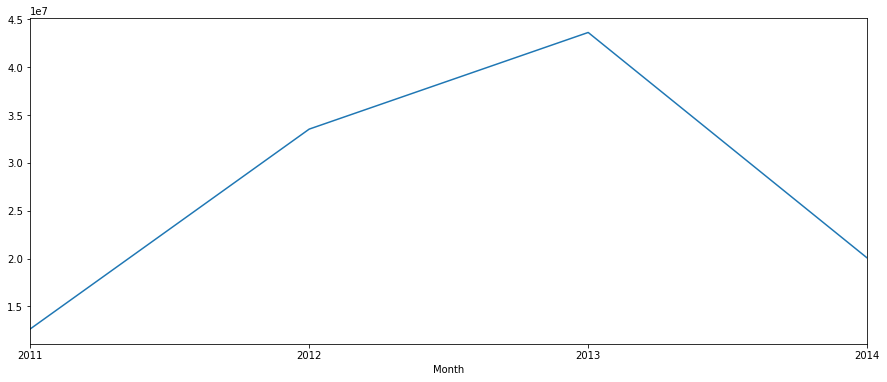

In [112]:
y = df['Sales'].resample('Y').sum()
y.plot(figsize=(15, 6))
plt.show()

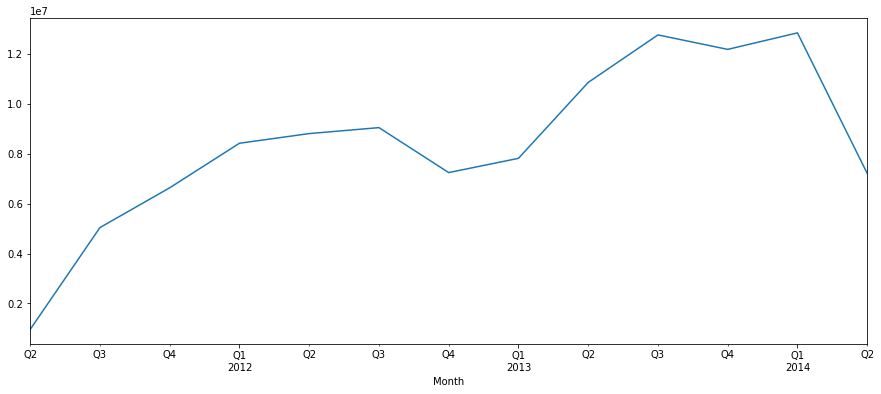

In [113]:
y = df['Sales'].resample('Q').sum()
y.plot(figsize=(15, 6))
plt.show()

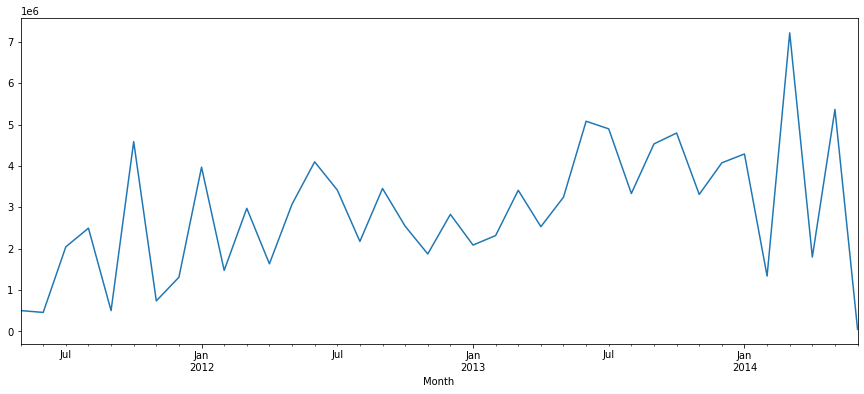

In [114]:
y = df['Sales'].resample('M').sum()
y.plot(figsize=(15, 6))
plt.show()

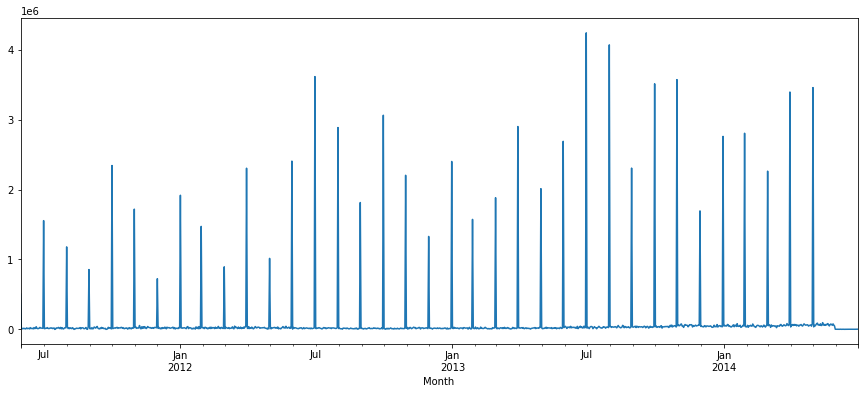

In [115]:
y = df['Sales'].resample('D').sum()
y.plot(figsize=(15, 6))
plt.show()

Nhận xét:
+ Ta thấy rằng xu hướng dữ liệu tăng dần từ năm 2011 đến đầu năm 2013 nhưng bắt đầu giảm dần từ sau đầu năm 2013-2014
+ Từ biểu đồ trên ta thấy rằng trường dữ liệu cũng có tính thời vụ khi ta thấy các quý có tăng và giảm đồng đều

# Auto Correlation

Muốn forecast = Arima thì trước tiên phải tìm được 3 giá trị sau p,d,q
P được tìm trong Auto Regressive, d được tìm trong check stationaly, q được tìm trong Auto Correlation

In [116]:
#resample data cho nhỏ lại để visualize dễ nhìn hơn
df=df.resample('M').sum()
df.shape

(38, 1)

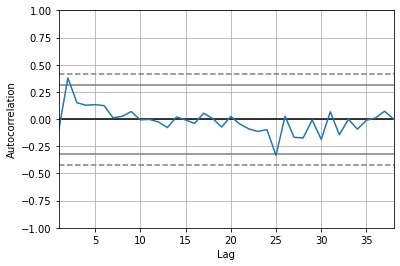

In [117]:
from matplotlib import pyplot
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
autocorrelation_plot(df)

Ta thấy rằng điểm có độ tương quan cao thì có lag=2

Sample Moving Average

In [118]:
SMA_60 = df.rolling('60D').mean()

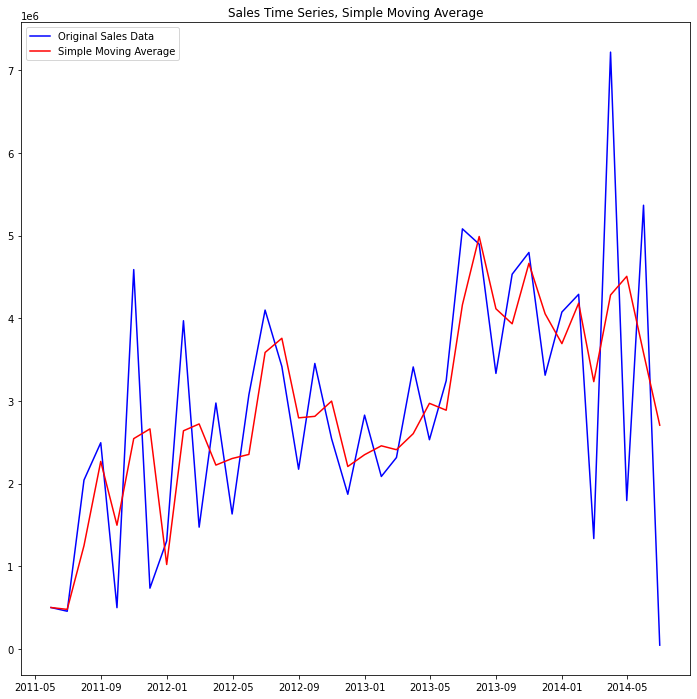

In [119]:
plt.figure(figsize=(12, 12))
plt.plot(df, color="blue",label="Original Sales Data")
plt.plot(SMA_60, color="red", label="Simple Moving Average")
plt.title("Sales Time Series, Simple Moving Average")
plt.legend(loc="best")

Exponential Moving Average

In [120]:
EMA_60 = df.ewm(alpha = 0.5,adjust=False).mean()

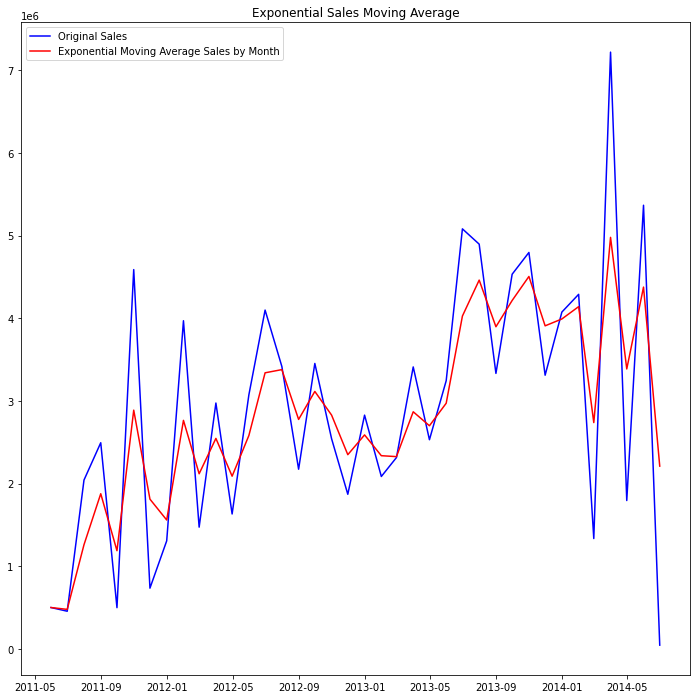

In [121]:
plt.figure(figsize=(12, 12))
plt.plot(df, color = 'blue', label='Original Sales')
plt.plot(EMA_60, color = 'red', label ='Exponential Moving Average Sales by Month')
plt.title("Exponential Sales Moving Average")
plt.legend();

Ta có q=2

# Auto Regressive

In [122]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


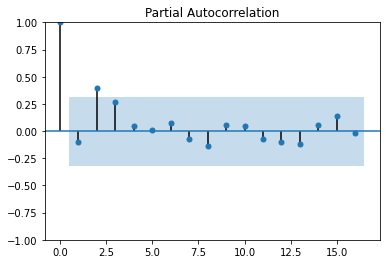

In [123]:
plot_pacf(df)
plt.show()

Ta thấy rằng 3 lag đầu có sự tương quan khá ổn

In [124]:
df_train, df_test = train_test_split(df, test_size=10, shuffle=False)
model = AutoReg(df_train, lags=3)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)

Coefficients: const       1.494051e+06
Sales.L1   -9.021633e-02
Sales.L2    1.757644e-01
Sales.L3    4.620069e-01
dtype: float64


In [125]:
from sklearn.metrics import mean_absolute_percentage_error
predictions = model_fit.predict(start=len(df_train),end=len(df_train)+len(df_test)-1,dynamic=False)
predictions
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions.iloc[i], df_test.iloc[i]))
mapse = mean_absolute_percentage_error(df_test,predictions)
print(f'Test Mean Absolute Percentage Error: {mapse:.3f} %') 

predicted=4401366.440924, expected=4532908.705303
predicted=3945116.972784, expected=4795813.289802
predicted=3452054.740557, expected=3312130.245587
predicted=3909491.809042, expected=4075486.625601
predicted=3570770.310568, expected=4289817.950953
predicted=3453931.552680, expected=1337725.035600
predicted=3616276.191589, expected=7217531.091974
predicted=3424602.291607, expected=1797173.923000
predicted=3416448.513779, expected=5366674.969338
predicted=3458499.000237, expected=49005.840000
Test Mean Absolute Percentage Error: 7.338 %


Ta thấy rằng vì data bị ngắt quãng nên kết quả ra khá xấu

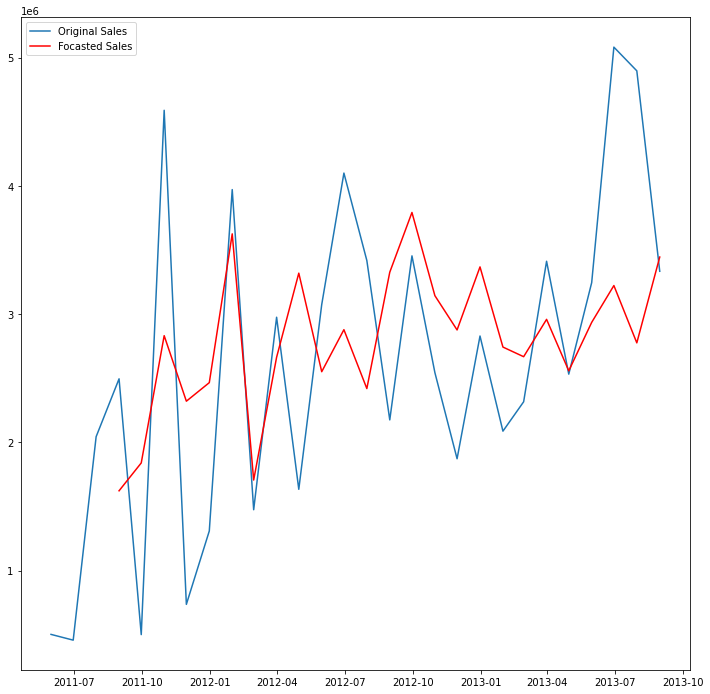

In [126]:
predictions = model_fit.predict(start=0,end=len(df_train) - 1)
plt.figure(figsize=(12, 12))
plt.plot(df_train, label='Original Sales')
plt.plot(predictions, color="red", label='Focasted Sales')
plt.legend();

Ta có p=3

# Check Stationarity

In [127]:
from statsmodels.tsa.stattools import adfuller

In [128]:
adft = adfuller(df,autolag="AIC")

In [129]:
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

      Values                       Metric
0  -3.353050              Test Statistics
1   0.012667                      p-value
2   1.000000             No. of lags used
3  36.000000  Number of observations used
4  -3.626652          critical value (1%)
5  -2.945951          critical value (5%)
6  -2.611671         critical value (10%)


Ta có P-value<0.05, d=0

In [ ]:
#Trong trường hợp p-value nó lớn hơn 0.05 thì sử dụng code sau
first_diff = df['Sales'] - df['Sales'].shift(1)
first_diff = first_diff.dropna(inplace=False)
adft =  adfuller(first_diff,autolag="AIC")
#Nếu kết quả output mà lại lớn hơn 0.05 thì lặp lại bước trên nhưng thay vì là first_diff thì sẽ là second_diff (lần này first_diff sẽ là base data)
#Với mỗi lần lặp lại việc trừ dữ liệu thì tăng giá trị của d thêm 1 đơn vị

# Xây dựng mô hình với ARIMA

In [130]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df, order=(3,0,2))
model.tolerance = 1e-4
model_fit = model.fit()

In [131]:
old_pred = model_fit.predict(df.index[0], df.index[-1], dynamic=False)
mapse = mean_absolute_percentage_error(df, old_pred)
print(f'Test Mean Absolute Percentage Error: {mapse:.3f} %') 

Test Mean Absolute Percentage Error: 2.443 %


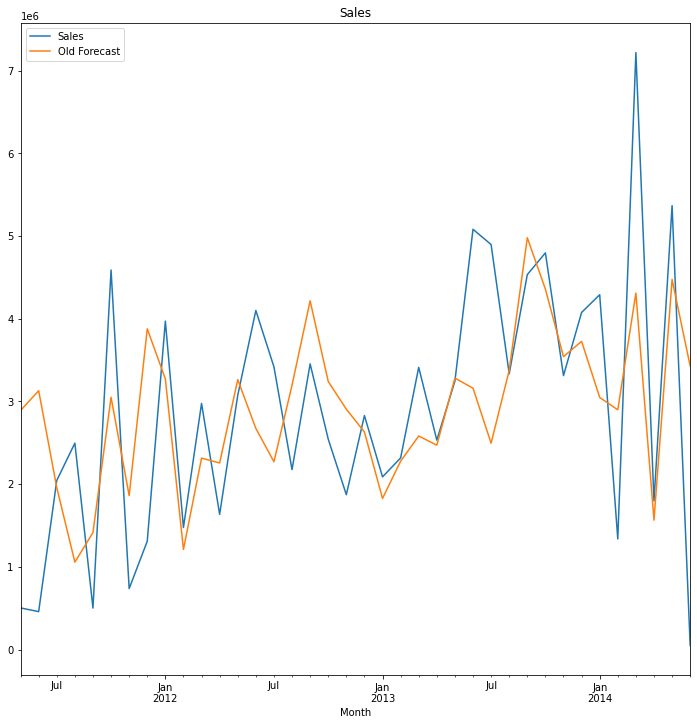

In [132]:
ax = df.plot(figsize=(12, 12))
old_pred.plot(label='Old Forecast')
ax.set_title("Sales")
ax.legend();


# Forecasting for future

In [133]:
from pandas.tseries.offsets import DateOffset
#Forecast đến năm tiếp theo
forecast_result = model_fit.get_forecast(df.index[-1]+ 2*pd.offsets.YearEnd())
forecast = forecast_result.predicted_mean
forecast_conf = forecast_result.conf_int()
forecast

2014-07-31    5.322542e+06
2014-08-31    1.685118e+06
2014-09-30    2.449339e+06
2014-10-31    2.244872e+06
2014-11-30    2.512841e+06
2014-12-31    2.618511e+06
2015-01-31    2.733435e+06
2015-02-28    2.796940e+06
2015-03-31    2.839884e+06
2015-04-30    2.863614e+06
2015-05-31    2.877220e+06
2015-06-30    2.884300e+06
2015-07-31    2.887922e+06
2015-08-31    2.889634e+06
2015-09-30    2.890395e+06
2015-10-31    2.890691e+06
2015-11-30    2.890781e+06
2015-12-31    2.890788e+06
Freq: M, Name: predicted_mean, dtype: float64

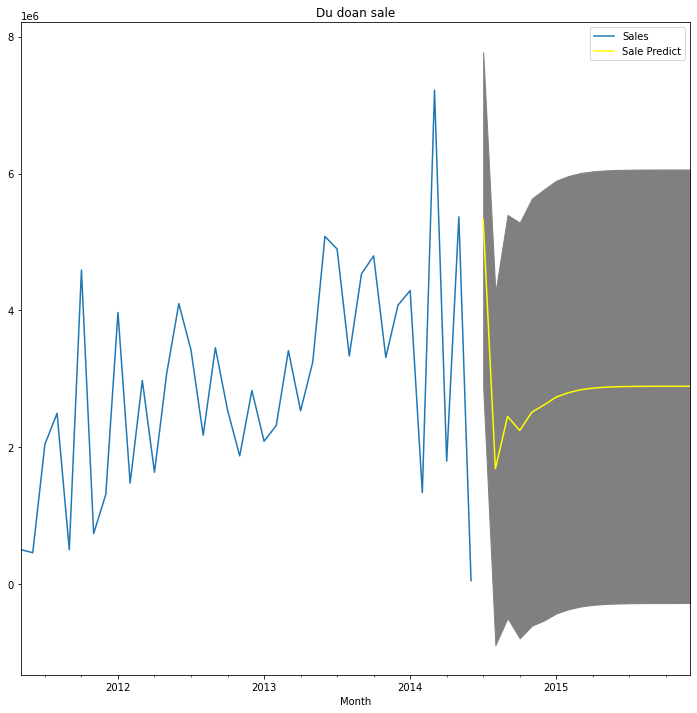

In [134]:
ax = df.plot(figsize=(12, 12))
forecast.plot(label='Sale Predict', color = 'Yellow')
ax.fill_between(forecast_conf.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1], color='gray')
ax.set_title("Du doan sale")
ax.legend();

# Auto Arima

In [135]:
from pmdarima.arima import auto_arima
model = auto_arima(df_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(df_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=840.048, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=853.700, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=844.655, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=847.089, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=851.826, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=837.825, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=841.059, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=835.675, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=837.812, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=839.637, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=836.570, Time=0.02 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.583 seconds


ARIMA(order=(2, 1, 0), scoring_args={}, suppress_warnings=True)

Dựa trên Auto Arima thì ta thấy được rằng p=5,d=1,q=2

In [136]:
#Xây dựng mô hình Arima
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df, order=(2,1,0))
model.tolerance = 1e-4
model_fit = model.fit()

In [137]:
old_pred = model_fit.predict(df.index[0], df.index[-1], dynamic=False)
mapse = mean_absolute_percentage_error(df, old_pred)
print(f'Test Mean Absolute Percentage Error: {mapse:.3f} %') 

Test Mean Absolute Percentage Error: 2.396 %


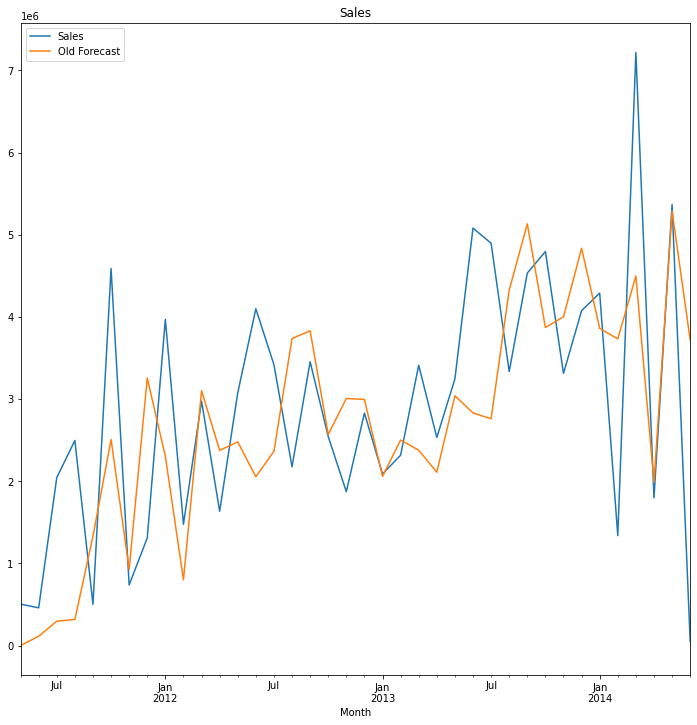

In [138]:
ax = df.plot(figsize=(12, 12))
old_pred.plot(label='Old Forecast')
ax.set_title("Sales")
ax.legend();

In [139]:
forecast_result = model_fit.get_forecast(df.index[-1]+ 2*pd.offsets.YearEnd())
forecast = forecast_result.predicted_mean
forecast

2014-07-31    4.399807e+06
2014-08-31    1.849955e+06
2014-09-30    2.824350e+06
2014-10-31    2.825774e+06
2014-11-30    2.413716e+06
2014-12-31    2.866776e+06
2015-01-31    2.541564e+06
2015-02-28    2.708746e+06
2015-03-31    2.661690e+06
2015-04-30    2.643067e+06
2015-05-31    2.683394e+06
2015-06-30    2.646841e+06
2015-07-31    2.670095e+06
2015-08-31    2.659892e+06
2015-09-30    2.661329e+06
2015-10-31    2.664045e+06
2015-11-30    2.660449e+06
2015-12-31    2.663264e+06
Freq: M, Name: predicted_mean, dtype: float64

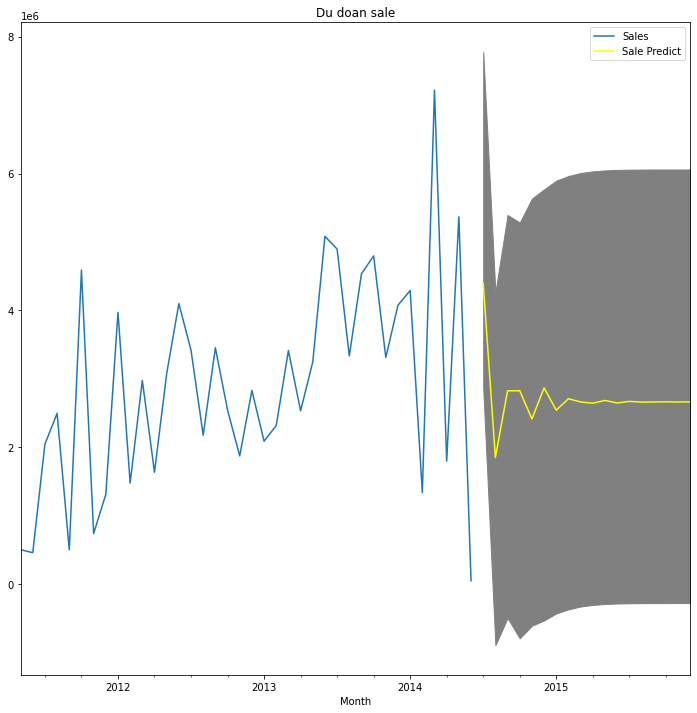

In [140]:
ax = df.plot(figsize=(12, 12))
forecast.plot(label='Sale Predict', color = 'Yellow')
ax.fill_between(forecast_conf.index, forecast_conf.iloc[:, 0], forecast_conf.iloc[:, 1], color='gray')
ax.set_title("Du doan sale")
ax.legend();

# Nhận xét và kết luận

Có vẻ là với p=2,d=1,q=0 thì dữ liệu sẽ predict đúng hơn với độ sai chỉ khoảng 2%
Dựa vào forecast trên thì ta thấy khi tự cho khoảng (p,d,q) thì dự doán dữ liệu sẽ có nhiều biến động nhưng với auto Arima thì kết quả biến động lúc đầu nhưng càng về sau thì sẽ càng ít sự dao động đi
Vậy để chạy dataset này theo mức tháng thì ta nên dùng khoảng như sau (2,1,0) để có dữ liệu dự đoán có nhiều trường hợp để có chính sách đối phó và xử lý trong tương lai